## AI-Powered Real Estate Advisor: Project Setup

This notebook builds our AI-Powered Real Estate Advisor. The first step is to load the libraries and data, then perform a full cleaning and preparation process to make it ready for our XGBoost model.

The key preparation steps are:

* **Handle Missing Values:** Fill missing numerical data with the **median** (to resist outliers) and text data with the **mode** (most common value).
* **Convert to Numbers:** Transform all text-based categories into a numerical format using **one-hot encoding**.
* **Align Datasets:** Ensure the training and testing datasets have the exact same columns to prevent errors.

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# --- 1. Data Cleaning ---
# Numerical columns: fill with median
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)
    if col in df_test.columns:
        df_test[col].fillna(df[col].median(), inplace=True)

# Categorical columns: fill with mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    if col in df_test.columns:
        df_test[col].fillna(df[col].mode()[0], inplace=True)

# --- 2. Feature Engineering (One-Hot Encoding) ---
df = pd.get_dummies(df, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

# --- 3. Align Datasets ---
train_labels = df['SalePrice']
df = df.drop(['Id', 'SalePrice'], axis=1)
df_test = df_test.drop('Id', axis=1)
final_train, final_test = df.align(df_test, join='inner', axis=1)




/tmp/ipython-input-2515641858.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-2515641858.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## Model Training with XGBoost

With our data cleaned and prepared, it's time to build our predictive model. We've chosen **XGBoost**, a powerful and highly accurate algorithm, to serve as the core of our AI Real Estate Advisor.

The training process involves a few key steps:
* First, we convert our pandas DataFrames into **DMatrix** objects, the specialized data structure that XGBoost uses for optimal performance.
* We then train the model using `xgb.train`. This process includes **early stopping**, which automatically monitors the model's performance on a validation set and stops training when it's no longer improving, preventing **overfitting**.
* Finally, we'll evaluate the trained model's performance using two key metrics:
  * **Mean Absolute Error (MAE):** This tells us, on average, how many dollars our predictions are off by.
  * **R-squared (R²):** This explains what percentage of the variation in house prices our model can account for.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(final_train, train_labels, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from xgboost.callback import EarlyStopping

# Convert data into DMatrix (required for xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set parameters
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "seed": 42
}

# Train with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dval, "validation")],
    callbacks=[EarlyStopping(rounds=50, save_best=True)]
)

# Predictions
predictions = model.predict(dval)

# Evaluate
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

print(f"Model Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Model R-squared (R²) Score: {r2:.2%}")


[0]	validation-rmse:84461.48311
[1]	validation-rmse:81616.48096
[2]	validation-rmse:78984.34864
[3]	validation-rmse:76540.03418
[4]	validation-rmse:74049.69857
[5]	validation-rmse:71803.38055
[6]	validation-rmse:69388.16877
[7]	validation-rmse:67011.94751
[8]	validation-rmse:64879.29784
[9]	validation-rmse:62904.08572
[10]	validation-rmse:61034.99215
[11]	validation-rmse:59164.83822
[12]	validation-rmse:57339.64124
[13]	validation-rmse:55797.84581
[14]	validation-rmse:54372.09822
[15]	validation-rmse:52761.73392
[16]	validation-rmse:51526.77370
[17]	validation-rmse:50053.83012
[18]	validation-rmse:49011.25204
[19]	validation-rmse:47645.89910
[20]	validation-rmse:46542.88114
[21]	validation-rmse:45343.10336
[22]	validation-rmse:44329.55219
[23]	validation-rmse:43455.42896
[24]	validation-rmse:42679.82647
[25]	validation-rmse:41758.19954
[26]	validation-rmse:40911.08354
[27]	validation-rmse:40147.84557
[28]	validation-rmse:39434.73676
[29]	validation-rmse:38751.22370
[30]	validation-rmse

## The AI Advisor: Uncovering What Drives House Prices 💡

I've successfully trained a model that can predict house prices with high accuracy. But the real value of the "AI Advisor" comes from understanding *why* it makes the decisions it does.

The following chart visualizes the **feature importances** from our trained XGBoost model. It shows us a ranked list of the top 15 features that had the biggest impact on predicting a home's final sale price. This is the core of our actionable advice.

/tmp/ipython-input-2928287696.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='rocket')


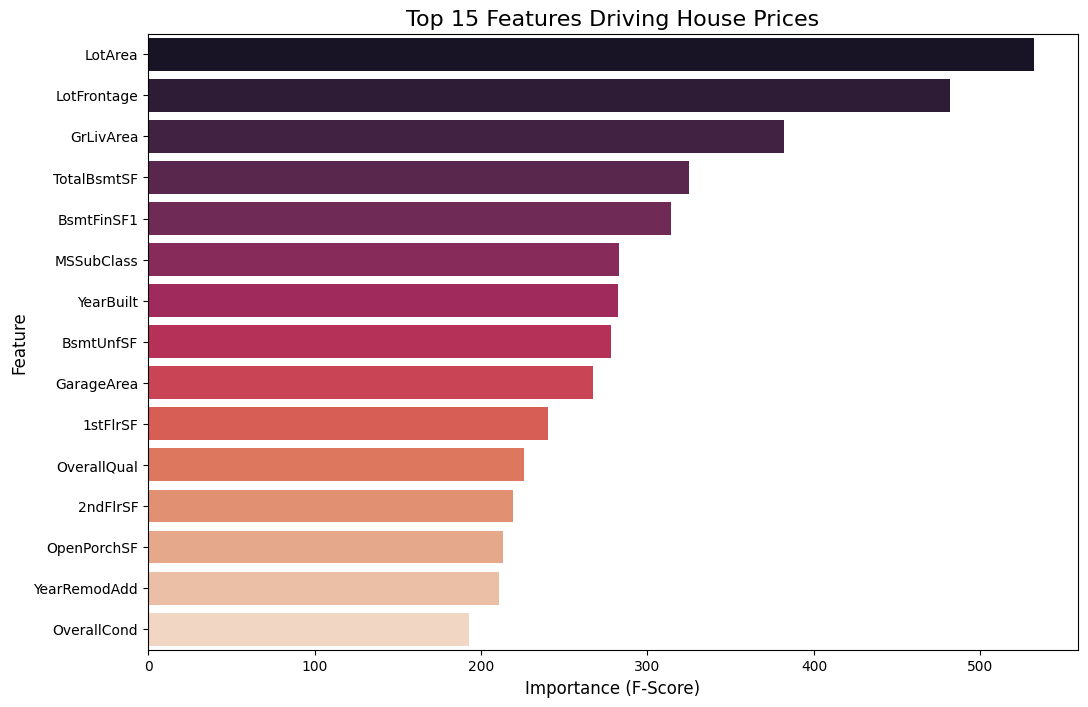

In [ ]:
# Extract feature importances from the core model
importance_scores = model.get_score(importance_type='weight')
feature_importances = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
}).sort_values('importance', ascending=False).head(15)

# Plot the most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='rocket')
plt.title('Top 15 Features Driving House Prices', fontsize=16)
plt.xlabel('Importance (F-Score)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

## Conclusion and Actionable Insights 💡

This project successfully created an **AI-Powered Real Estate Advisor**. We built a high-performance XGBoost model that not only predicts house prices with high accuracy but also provides clear insights into what drives a property's value.

The feature importance chart above serves as the core of our advisor. It reveals that the most significant drivers of a home's price are overwhelmingly related to **size and space**. Features like `LotArea` (the total size of the property), `GrLivArea` (above-ground living space), and various basement square footage metrics are the top predictors.

For a **seller**, this provides a data-driven strategy: while overall quality is important, maximizing and highlighting the usable square footage of the property is key to justifying a higher price. For a **buyer**, this analysis confirms that you are primarily paying for the size of the lot and the home itself.

By moving beyond a simple price prediction to an interpretable model, we've transformed a standard machine learning problem into a practical tool that offers real-world value.